## Load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tweepy
import datetime
import calendar
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

DIR = "./data/"
EGO_TIMELINES = DIR + "EgoTimelines.txt"
EGO_ALTER_PROFILES = DIR + "EgoAlterProfiles.txt"

ego_timelines = pd.read_csv( EGO_TIMELINES, sep='\t',encoding = "ISO-8859-1")
ego_alter = pd.read_csv( EGO_ALTER_PROFILES, sep='\t',encoding = "ISO-8859-1")

## Merge the ego's timelines and profiles

This part is similar to the one some of us did in the replication part of P4. 

In the first part, we want to change the strings in `created_at` to datetimes.

In [2]:
ego_timelines['created_at'] = ego_timelines['created_at'].apply(lambda x: x.replace('+0000', ''))
ego_timelines['created_at'] = ego_timelines['created_at'].apply(lambda x: datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %Y"))

In [3]:
ego_alter['created_at'] = ego_alter['created_at'].apply(lambda x: x.replace('+0000', ''))
ego_alter['created_at'] = ego_alter['created_at'].apply(lambda x: datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %Y"))

We decided not to follow the step from the replication to use only egos which have a defined `utc_offset` as we reckon it does not affect our result too much, it would only affect tweets made on the first or last day of the month.

In [4]:
egos_only = ego_alter[ego_alter['IsEgo']]

We merge the two datasets, based on the ID that was assigned to them by the authors of the paper.

In [5]:
merged = ego_timelines.merge(egos_only, left_on = 'egoID', right_on = 'ID', suffixes = ('_timelines', '_profiles'))

We add three columns representing the month and the year at which the tweet was posted and the year at which the account was created.

In [6]:
merged['month_post'] = merged['created_at_timelines'].apply(lambda x: calendar.month_name[x.month])
merged['year_post'] = merged['created_at_timelines'].apply(lambda x: x.year)
merged['year_account'] = merged['created_at_profiles'].apply(lambda x: x.year)

In [7]:
merged.head()

,replyto_userid,retweeted_userid,id,tweetid,created_at_timelines,hashtags,urls,mentions_ids,retweet_count,egoID,...,followers_count,friends_count,statuses_count,utc_offset,lang,created_at_profiles,protected,month_post,year_post,year_account
0,NaN,NaN,398477318,249552537051598848,2012-09-22 16:55:35,NaN,NaN,2810549959,0,1,...,30.0,28,9.0,NaN,en,2011-10-26 03:30:32,False,September,2012,2011
1,NaN,NaN,398477318,249537963145433088,2012-09-22 15:57:41,NaN,NaN,2810549959,0,1,...,30.0,28,9.0,NaN,en,2011-10-26 03:30:32,False,September,2012,2011
2,NaN,NaN,398477318,129377372209299456,2011-10-27 02:02:23,NaN,NaN,NaN,0,1,...,30.0,28,9.0,NaN,en,2011-10-26 03:30:32,False,October,2011,2011
3,NaN,NaN,398477318,302401054690140160,2013-02-15 12:56:44,NaN,NaN,797583722,0,1,...,30.0,28,9.0,NaN,en,2011-10-26 03:30:32,False,February,2013,2011
4,NaN,NaN,398477318,249538739611787264,2012-09-22 16:00:46,NaN,NaN,2810549959,0,1,...,30.0,28,9.0,NaN,en,2011-10-26 03:30:32,False,September,2012,2011


## Barplot of the number of tweets per month

We will select only the tweets of a given year, done by user which account was created before the start of this year. This is done as a way to reduce bias as a user whose account was created in June could not have posted any tweets before.

In [8]:
month_count = merged['month_post'][(merged['year_post'] == 2012) & (merged['year_account'] < 2012)].value_counts()

Text(0, 0.5, 'Number of tweets')

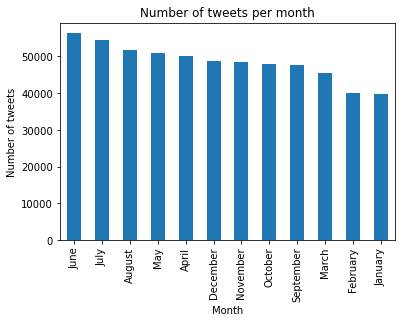

In [9]:
month_count.plot.bar()
plt.title("Number of tweets per month")
plt.xlabel("Month")
plt.ylabel("Number of tweets")

## Load the data gathered with Twitter API

In [17]:
# Let's name the set of new data ego_new_info
EGO_NEW_INFO = DIR + "recent_user_information.csv"
EGO_DEL = DIR + "deleted_account.csv"

ego_new_info = pd.read_csv(EGO_NEW_INFO, header = 0)
ego_del = pd.read_csv(EGO_DEL, header = 0)

The columns `id`, `statuses_count`, `followers_count` and `friends_count` are the only ones we will use for the models.

In [24]:
ego_new_small = ego_new_info[['id', 'statuses_count', 'followers_count', 'friends_count']]
merged_small = merged[['id', 'statuses_count', 'followers_count', 'friends_count']].drop_duplicates()

In [25]:
active_users = merged_small.merge(ego_new_small, left_on = 'id', right_on = 'id', suffixes = ('_2014', '_2020'))

In [28]:
active_users.head()

,id,statuses_count_2014,followers_count_2014,friends_count_2014,statuses_count_2020,followers_count_2020,friends_count_2020
0,194700833,7.0,13.0,9,7,12,9
1,114163235,6.0,26.0,16,6,29,17
2,363054646,180.0,6.0,10,268,6,17
3,294643774,49.0,12.0,45,52,20,53
4,228786247,18.0,13.0,39,8,16,33


## Train the models

The output we want to predict is always `statuses_count_2020` and we will use all the other columns except for `id` as input.

In [39]:
features = ['followers_count_2014', 'friends_count_2014', 'statuses_count_2014', 'followers_count_2020', 'friends_count_2020']
output = 'statuses_count_2020'

To split the data, we will use `train_test_split` from `sklearn` as we did in HW2.

In [31]:
test_size = 0.7

trainset, testset = train_test_split(active_users[features + output], test_size = test_size, shuffle = True)

We will try two different models, `GradientBoostingRegressor` and `Ridge`. This follows the same pattern as in HW2, so we won't go into too much details about our steps.

In [42]:
train_x = trainset[features]
train_y = trainset[output]
test_x = testset[features]
test_y = testset[output]

In [43]:
gbr = GradientBoostingRegressor()

gbr.fit(train_x, train_y)

GradientBoostingRegressor()

In [46]:
pred_gbr = gbr.predict(test_x)
r2_gbr = r2_score(test_y, pred_gbr)

In [47]:
rr = Ridge()

rr.fit(train_x, train_y)

Ridge()

In [48]:
pred_rr = rr.predict(test_x)
r2_rr = r2_score(test_y, pred_rr)

In [49]:
print("R\u00b2 is {} for GBR and {} for RR".format(r2_gbr, r2_rr))

R² is 0.08006321101982461 for GBR and 0.6815907303318928 for RR


Ridge regression seems to be a better fit for our task. We will still do some cross validation on GBR just to be sure.

## Cross-validation

Let's do some cross-validation on `learning_rate` and `n_estimators` for `GradientBoostingRegressor`, and on `alpha` for `Ridge`.

We will take the same values for `GradientBoostingRegressor` as we did in HW2, and for `Ridge`, we will try some alpha following a log space.

In [68]:
n_estimators = [50, 75, 100, 150, 200, 250]
learning_rates = [0.1, 0.05, 0.01]
alpha = np.logspace(-7, 7, 15)

In [64]:
values_gbr = pd.DataFrame({'n_estimator': [], 'learning_rate': [], 'R^2': []})
for n in n_estimators :
    for lr in learning_rates :
        new_entry = {'n_estimator': n, 'learning_rate': lr, 'R^2':0}
        temp_gbr = GradientBoostingRegressor(n_estimators = n, learning_rate = lr)
        pred = cross_val_predict(temp_gbr, train_x, train_y, cv = 20)
        new_entry['R^2'] = r2_score(train_y, pred)
        values_gbr = values_gbr.append(new_entry, ignore_index = True)

In [65]:
values_gbr

,n_estimator,learning_rate,R^2
0,50.0,0.10,0.555701
1,50.0,0.05,0.540745
2,50.0,0.01,0.349160
3,75.0,0.10,0.562714
4,75.0,0.05,0.551813
5,75.0,0.01,0.427914
6,100.0,0.10,0.559207
7,100.0,0.05,0.546565
8,100.0,0.01,0.475003
9,150.0,0.10,0.565949


In [69]:
values_rr = pd.DataFrame({'alpha': [], 'R^2': []})
for a in alpha :
    new_entry = {'alpha': a, 'R^2': 0}
    temp_rr = Ridge(alpha = a)
    pred = cross_val_predict(temp_rr, train_x, train_y, cv = 20)
    new_entry['R^2'] = r2_score(train_y, pred)
    values_rr = values_rr.append(new_entry, ignore_index = True)

In [70]:
values_rr

,alpha,R^2
0,1.000000e-07,0.633703
1,1.000000e-06,0.633703
2,1.000000e-05,0.633703
3,1.000000e-04,0.633703
4,1.000000e-03,0.633703
5,1.000000e-02,0.633703
6,1.000000e-01,0.633703
7,1.000000e+00,0.633703
8,1.000000e+01,0.633703
9,1.000000e+02,0.633704


In [72]:
pred_gbr

array([  27.54302211,  264.26750934,   27.54302211, ...,  178.57786811,
         27.54302211, 1651.71052379])